In [2]:
import pandas as pd
import numpy as np
import os

from time import time
from sklearn.datasets import make_hastie_10_2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import hog

In [3]:
NAMES_PATH = "./data/archive/lfw_allnames.csv"
IMAGES_PATH = "./data/archive/lfw-deepfunneled/lfw-deepfunneled"

In [4]:
df_names = pd.read_csv(NAMES_PATH)
# To get a better performance, here we set a lower bound for the size of the dataset
min_faces_per_person = 80 
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])
K = len(names)
names

['Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Tony_Blair']

In [5]:
# data preprocessing procedure
X = []
Y = []
for name in names:
    dir_path = os.path.join(IMAGES_PATH, name)
    list_images_name = os.listdir(dir_path)
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        img_rgb = plt.imread(image_path)
        X.append(img_rgb)
        Y.append(name)
    print(f"Class: {name}, number of samples: {len(list_images_name)}.")

X = np.asarray(X)
Y = np.asarray(Y)

print(X.shape, Y.shape)

Class: Colin_Powell, number of samples: 236.
Class: Donald_Rumsfeld, number of samples: 121.
Class: George_W_Bush, number of samples: 530.
Class: Gerhard_Schroeder, number of samples: 109.
Class: Tony_Blair, number of samples: 144.
(1140, 250, 250, 3) (1140,)


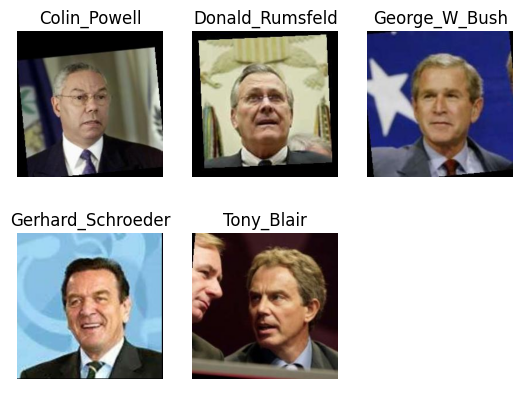

In [6]:
# an overview of the pictures
_, indices = np.unique(Y, return_index=True)
columns = 3
rows = (len(indices) // columns) + 1
fig, axs = plt.subplots(frameon=False)
axs.axis('off')

for itr, idx in enumerate(indices):
    # Adds a subplot at the 2nd position 
    fig.add_subplot(rows, columns, itr+1) 
    plt.axis('off')
    plt.title(Y[idx]) 
    plt.imshow(X[idx])
    
plt.show()

In [7]:
def create_features(img, show_hog=False):
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

In [8]:
feature_matrix = []
for x in X:
    feature_matrix.append(create_features(x))

In [16]:
# get shape of feature matrix
feature_matrix = np.asarray(feature_matrix)
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=800)
# use fit_transform to run PCA on our standardized matrix
pca.fit(bees_stand)
X_pca = pca.transform(bees_stand)
print('PCA matrix shape is: ', X_pca.shape)

Feature matrix shape is:  (1140, 201189)
PCA matrix shape is:  (1140, 800)


In [17]:
# label_encoder object knows  
# how to understand word labels. 
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y) 

In [18]:
# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, random_state=42, test_size=0.2)

In [82]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
p_num = 0
for _, _ in enumerate(indices):
    p_num = p_num+1

kdt = KDTree(X_train, leaf_size=2)
dis, ind = kdt.query(X_train[:1], k=3)
print(dis)

[[  0.         343.69338693 368.43939946]]


In [88]:
import math
def dist(X, Y):
    return np.sum(np.power((X-Y), 2), axis=1)

class MyKnn:
    def __init__(self, k=3, n_class=100):
        self.k = k
        self.n_class = n_class
    
    def fit_and_predict(self, X_train, X_test, y_train):
        N = X_test.shape[0]
        y_pred = np.zeros(N)
        for i in range(N):
            d = dist(X_train, X_test[i])
            sort = np.argsort(d, kind="quicksort")[:self.k]
            cnt = np.zeros(self.n_class)
            for s in sort:
                cnt[y_train[s]] += 1
            y_pred[i] = np.argmax(cnt)
        return y_pred
    
    def fit_and_predict_weight(self, X_train, X_test, y_train):
        N = X_test.shape[0]
        y_pred = np.zeros(N)
        for i in range(N):
            d = dist(X_train, X_test[i])
            sort = np.argsort(d, kind="quicksort")[:self.k]
            w = []
            for j in range(self.k):
                w_ = (d[sort[self.k-1]]-d[sort[j]])/(d[sort[self.k-1]]-d[sort[0]])
                w.append(w_)
            cnt = np.zeros(self.n_class)
            Idx = 0
            for s in sort:
                cnt[y_train[s]] += w[Idx]
                Idx += 1
            y_pred[i] = np.argmax(cnt)
        return y_pred
    
    def fit_and_predict_by_kdtree(self, X_train, X_test, y_train):
        distance, index = kdt.query(X_test, k=self.k)
        N = X_test.shape[0]
        y_pred = np.zeros(N)
        for i in range(N):
            w = []
            for j in range(self.k):
                w_ = (distance[i][self.k-1]-distance[i][j])/(distance[i][self.k-1]-distance[i][0])
                w.append(w_)
            cnt = np.zeros(self.n_class)
            Idx = 0
            for D in index[i]:
                cnt[y_train[D]] += w[Idx]
                Idx += 1
            y_pred[i] = np.argmax(cnt)
        return y_pred

In [89]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import time
myKnn = MyKnn(k=2, n_class=p_num)
y_pred = myKnn.fit_and_predict(X_train, X_test, Y_train)
acc = 0
M = Y_test.shape[0]
for i in range(M):
    if y_pred[i] == Y_test[i]:
        acc += 1.0
acc /= M
best_param = 2
best_acc = acc
errs = []
T1 = []
for i in range(3, 50):
    st = time.time()
    myKnn = MyKnn(k=i, n_class=p_num)
    y_pred = myKnn.fit_and_predict(X_train, X_test, Y_train)
    et = time.time()
    T1.append(et-st)
    acc = 0
    for j in range(M):
        if y_pred[j] == Y_test[j]:
            acc += 1.0
    acc /= M
    errs.append(1-acc)
    if best_acc < acc:
        best_acc = acc
        best_param = i
print("best param is", best_param)
    

best param is 11


In [90]:
from sklearn import neighbors
errs_skKNN = []
T2 = []
for i in range(3, 50):
    st = time.time()
    skKNN = neighbors.KNeighborsClassifier(n_neighbors=i, p=2)
    skKNN.fit(X_train, Y_train)
    et = time.time()
    T2.append(et-st)
    errs_skKNN.append(1-skKNN.score(X_test, Y_test))

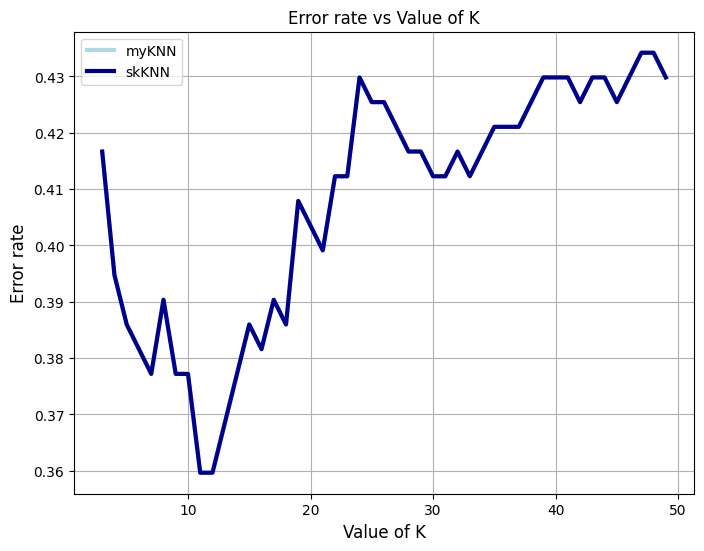

In [91]:
def plot_error_rate(err_myKNN, err_skKNN, times):
    df_error = pd.DataFrame({'myKNN':err_myKNN, 'skKNN':err_skKNN}, index=times)
    df_error.columns = ['myKNN', 'skKNN']
    myPlot = df_error.plot(linewidth=3, figsize=(8,6), color=['lightblue', 'darkblue'], grid=True)
    myPlot.set_xlabel('Value of K', fontsize=12)
    myPlot.set_ylabel('Error rate', fontsize=12)
    myPlot.set_title('Error rate vs Value of K')
    
plot_error_rate(errs, errs_skKNN, range(3, 50))

In [93]:
myKnn = MyKnn(k=2, n_class=p_num)
y_pred = myKnn.fit_and_predict_weight(X_train, X_test, Y_train)
acc = 0
M = Y_test.shape[0]
for i in range(M):
    if y_pred[i] == Y_test[i]:
        acc += 1.0
acc /= M
best_param = 2
best_acc = acc
errs_ = []
T3 = []
for i in range(3, 50):
    st = time.time()
    myKnn = MyKnn(k=i, n_class=p_num)
    y_pred = myKnn.fit_and_predict_weight(X_train, X_test, Y_train)
    et = time.time()
    T3.append(et-st)
    acc = 0
    for j in range(M):
        if y_pred[j] == Y_test[j]:
            acc += 1.0
    acc /= M
    errs_.append(1-acc)
    if best_acc < acc:
        best_acc = acc
        best_param = i
print("best param is", best_param)

best param is 18


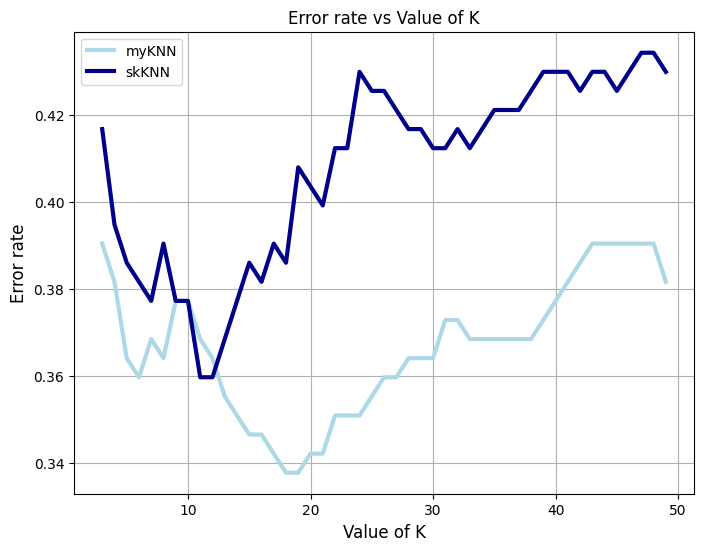

In [94]:
plot_error_rate(errs_, errs_skKNN, range(3, 50))

In [95]:
myKnn = MyKnn(k=2, n_class=p_num)
y_pred = myKnn.fit_and_predict_by_kdtree(X_train, X_test, Y_train)
acc = 0
M = Y_test.shape[0]
for i in range(M):
    if y_pred[i] == Y_test[i]:
        acc += 1.0
acc /= M
best_param = 2
best_acc = acc
errs__ = []
T4 = []
for i in range(3, 50):
    st = time.time()
    myKnn = MyKnn(k=i, n_class=p_num)
    y_pred = myKnn.fit_and_predict_by_kdtree(X_train, X_test, Y_train)
    et = time.time()
    T4.append(et-st)
    acc = 0
    for j in range(M):
        if y_pred[j] == Y_test[j]:
            acc += 1.0
    acc /= M
    errs__.append(1-acc)
    if best_acc < acc:
        best_acc = acc
        best_param = i
print("best param is", best_param)

best param is 18


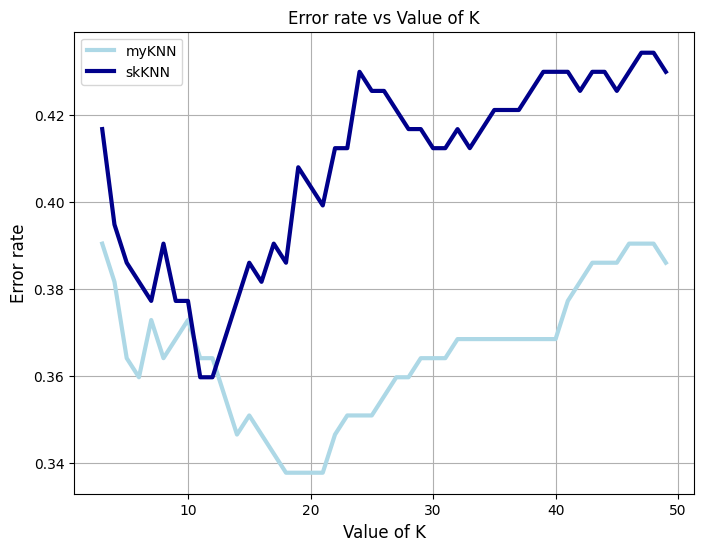

In [96]:
plot_error_rate(errs__, errs_skKNN, range(3, 50))

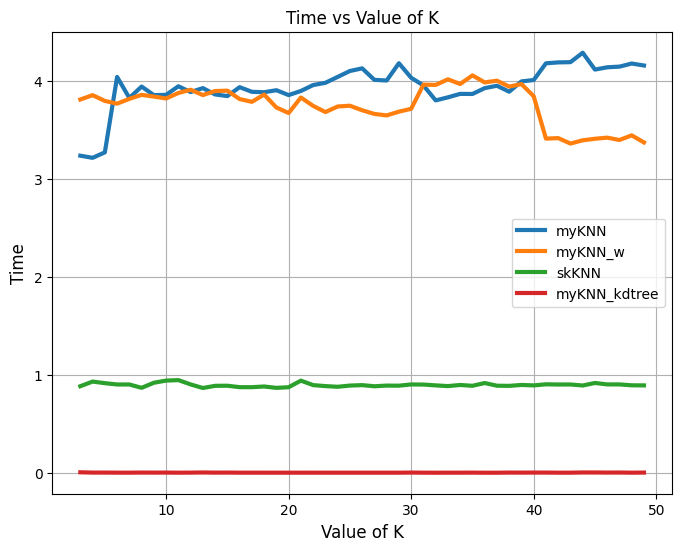

In [97]:
def plot_time(T1, T2, T3, T4, times):
    df_time = pd.DataFrame({'myKNN':T1, 'myKNN_w':T3, 'myKNN_kdtree':T4, 'skKNN':T2}, index=times)
    df_time.columns = ['myKNN', 'myKNN_w', 'skKNN', 'myKNN_kdtree']
    myPlot = df_time.plot(linewidth=3, figsize=(8,6),grid=True)
    myPlot.set_xlabel('Value of K', fontsize=12)
    myPlot.set_ylabel('Time', fontsize=12)
    myPlot.set_title('Time vs Value of K')
    
plot_time(T1, T2, T3, T4, range(3, 50))